In [1]:
# Imports and set torch device
import numpy as np
import meshplot as mp
import matplotlib.pyplot as plt
import kaolin as kal
import cv2
from collections import defaultdict
import trimesh
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print('Torch will run on:', device)

object = 'bookshelf' 
obj_path = 'data/demo/' + object + '.obj'

Torch will run on: cuda:0


In [2]:
# Read mesh
mesh = kal.io.obj.import_mesh(
    obj_path,
    with_normals=True,
    with_materials=False,
)

vertices_tensor = mesh.vertices.to(device)
faces_tensor = mesh.faces.to(device)

vertices = vertices_tensor.detach().cpu().numpy()
faces = faces_tensor.detach().cpu().numpy()
colors =  mesh.vertex_normals.cpu().numpy()

print('Number of vertices: ', vertices.shape[0])
print('Number of faces: ', faces.shape[0])

Number of vertices:  5786
Number of faces:  8624


In [3]:
# Visualize mesh
trimeshMesh = trimesh.Trimesh(vertices, faces)
# N = int(vertices.shape[0] * 2)
N = int(vertices.shape[0] / 2)
point_cloud, pt_to_face = trimesh.sample.sample_surface_even(trimeshMesh, N)
torchPC = torch.tensor(point_cloud, device=torch.device('cuda:0'), dtype=torch.float32)
face_to_all_pts = defaultdict(list)
for pt in range(len(point_cloud)):
    face_to_all_pts[pt_to_face[pt]].append(pt)
p = mp.plot(vertices, faces, colors, return_plot=True, shading={"wireframe": 0.1})
p.add_points(point_cloud, shading={"point_size": 0.1, "point_color": "green"})
plt.show()

only got 1839/2893 samples!


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

c:\ProgramData\miniforge3\envs\test_proj\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


In [4]:
def computeNormals(mesh, pt_to_face):
    face_normals = kal.ops.mesh.face_normals(
        kal.ops.mesh.index_vertices_by_faces(mesh.vertices.unsqueeze(0), mesh.faces), unit=True).squeeze()
    n_pts = len(pt_to_face)
    pts_normals = torch.zeros((n_pts, 3), device = device)
    for pt in range(n_pts):
        pts_normals[pt] = face_normals[pt_to_face[pt]]
    return pts_normals

pts_normals = computeNormals(mesh, pt_to_face)
mp.plot(point_cloud, c = pts_normals.cpu().numpy(), shading={'point_size':0.15})
plt.show()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

In [75]:
# Our SPC will contain a hierarchy of multiple levels
level = 8
torch.manual_seed(0)
# colors = torch.rand(point_cloud.shape[0], 3, device=device)
# colors = torch.tensor(point_cloud, device=device)
# colors = torch.tensor(point_cloud[:,:1]).to(device)
colors = torch.arange(0, point_cloud.shape[0]).unsqueeze(1).to(device)
mp.plot(point_cloud, c = colors.cpu().numpy(), shading={'point_size':0.2})

plt.show()
spc = kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(
    pointcloud=torchPC, level=level, features=colors)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

In [76]:
def _normalized_grid(width, height, device='cuda'):
    """Returns grid[x,y] -> coordinates for a normalized window.
    
    Args:
        width, height (int): grid resolution
    """

    # These are normalized coordinates
    # i.e. equivalent to 2.0 * (fragCoord / iResolution.xy) - 1.0
    window_x = torch.linspace(-1, 1, steps=width, device=device) * (width / height)
    window_y = torch.linspace(1,- 1, steps=height, device=device)

    coord = torch.stack(torch.meshgrid(window_x, window_y)).permute(1,2,0)
    return coord


def look_at(camera_from, camera_to, width, height, mode='persp', fov=90.0, device='cuda'):
    """Vectorized look-at function, returns an array of ray origins and directions
    URL: https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/lookat-function
    """

    camera_origin = torch.FloatTensor(camera_from).to(device)
    camera_view = F.normalize(torch.FloatTensor(camera_to).to(device) - camera_origin, dim=0)
    camera_right = F.normalize(torch.cross(camera_view, torch.FloatTensor([0,1,0]).to(device)), dim=0)
    camera_up = F.normalize(torch.cross(camera_right, camera_view), dim=0)

    coord = _normalized_grid(width, height, device=device)
    ray_origin = camera_right * coord[...,0,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_up * coord[...,1,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_origin + camera_view
    ray_origin = ray_origin.reshape(-1, 3)
    ray_offset = camera_view.unsqueeze(0).repeat(ray_origin.shape[0], 1)
    
    if mode == 'ortho': # Orthographic camera
        ray_dir = F.normalize(ray_offset, dim=-1)
    elif mode == 'persp': # Perspective camera
        ray_dir = F.normalize(ray_origin - camera_origin, dim=-1)
        ray_origin = camera_origin.repeat(ray_dir.shape[0], 1)
    else:
        raise ValueError('Invalid camera mode!')


    return ray_origin, ray_dir

In [77]:
# ray_o and ray_d ~ torch.Tensor (width x height, 3)
# represent rays origin and direction vectors
ray_o, ray_d = look_at(
                        camera_from=[-.5,2.5,-2.5],
                        # camera_from=[0.,0.,3.],
                        camera_to=[0,0.,0],
                        width=1024,
                        height=1024,
                        mode='persp',
                        fov=30,
                        device='cuda')

print(f'Total of {ray_o.shape[0]} rays generated.')

Total of 1048576 rays generated.


In [78]:
print(f'Rays: {ray_o.shape}')
print(f'Ray 0 Direction: {ray_d[0]}')

Rays: torch.Size([1048576, 3])
Ray 0 Direction: tensor([ 0.4110, -0.4758,  0.7776], device='cuda:0')


In [79]:
octree, features = spc.octrees, spc.features
point_hierarchy, pyramid, prefix = spc.point_hierarchies, spc.pyramids[0], spc.exsum
nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(
    octree, point_hierarchy, pyramid, prefix, ray_o, ray_d, level)
masked_nugs = kal.render.spc.mark_pack_boundaries(nugs_ridx)
nugs_ridx = nugs_ridx[masked_nugs]
nugs_pidx = nugs_pidx[masked_nugs]
print(f'Total of {nugs_ridx.shape[0]} nuggets were traced.')

Total of 55878 nuggets were traced.


In [81]:
print(f'Ray Hits: {nugs_ridx.shape}')
print(f'Point Hits: {nugs_pidx.shape}')

Ray Hits: torch.Size([55878])
Point Hits: torch.Size([55878])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


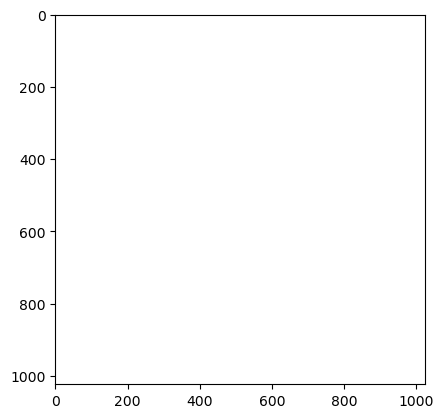

In [87]:
# 1. We initialize an empty canvas.
image = torch.ones_like(ray_o, dtype=torch.float64)

# 2. We'll query all first-hit nuggets to obtain their corresponding point-id (which cell they hit in the SPC).
ridx = nugs_ridx.long()
pidx = nugs_pidx.long() - pyramid[1,level]

# 3. We'll query the features auxilary structure to obtain the color.
# 4. We set each ray value as the corresponding nugget color.
image[ridx] = features[pidx].to(torch.float64)
image = image.reshape(1024, 1024, 3).cpu().numpy().transpose(1,0,2)
plt.imshow(image)
plt.show()

In [100]:
id_p = np.random.randint(ridx.shape[0])
print(f'Ray number: {id_p}')
ridx = nugs_ridx.long()
pidx = nugs_pidx.long() - pyramid[1,level]
m_ray = ridx[id_p]
m_ray_o = ray_o[m_ray]
m_ray_d = ray_d[m_ray]
m_hit = point_cloud[features[pidx[id_p]]]
# p = mp.plot(point_cloud, c = features.cpu().numpy(), shading={'point_size':0.2}, return_plot=True)
p = mp.plot(point_cloud, shading={'point_size':0.2, 'point_color':'black'}, return_plot=True)
p.add_points(m_ray_o.view(1, -1).cpu().numpy(), shading={'point_size':0.5, 'point_color':'green'})
p.add_points(m_hit.reshape(1, -1), shading={'point_size':0.5, 'point_color':'blue'})
p.add_lines(m_ray_o.view(1, -1).cpu().numpy(), (m_ray_o + 4*m_ray_d).view(1, -1).cpu().numpy(), 
            shading={'line_color':'blue'})
plt.show()

Ray number: 45725


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.4272670…

Total of 1077654 nuggets were traced.

Total of 62730 nuggets were traced.



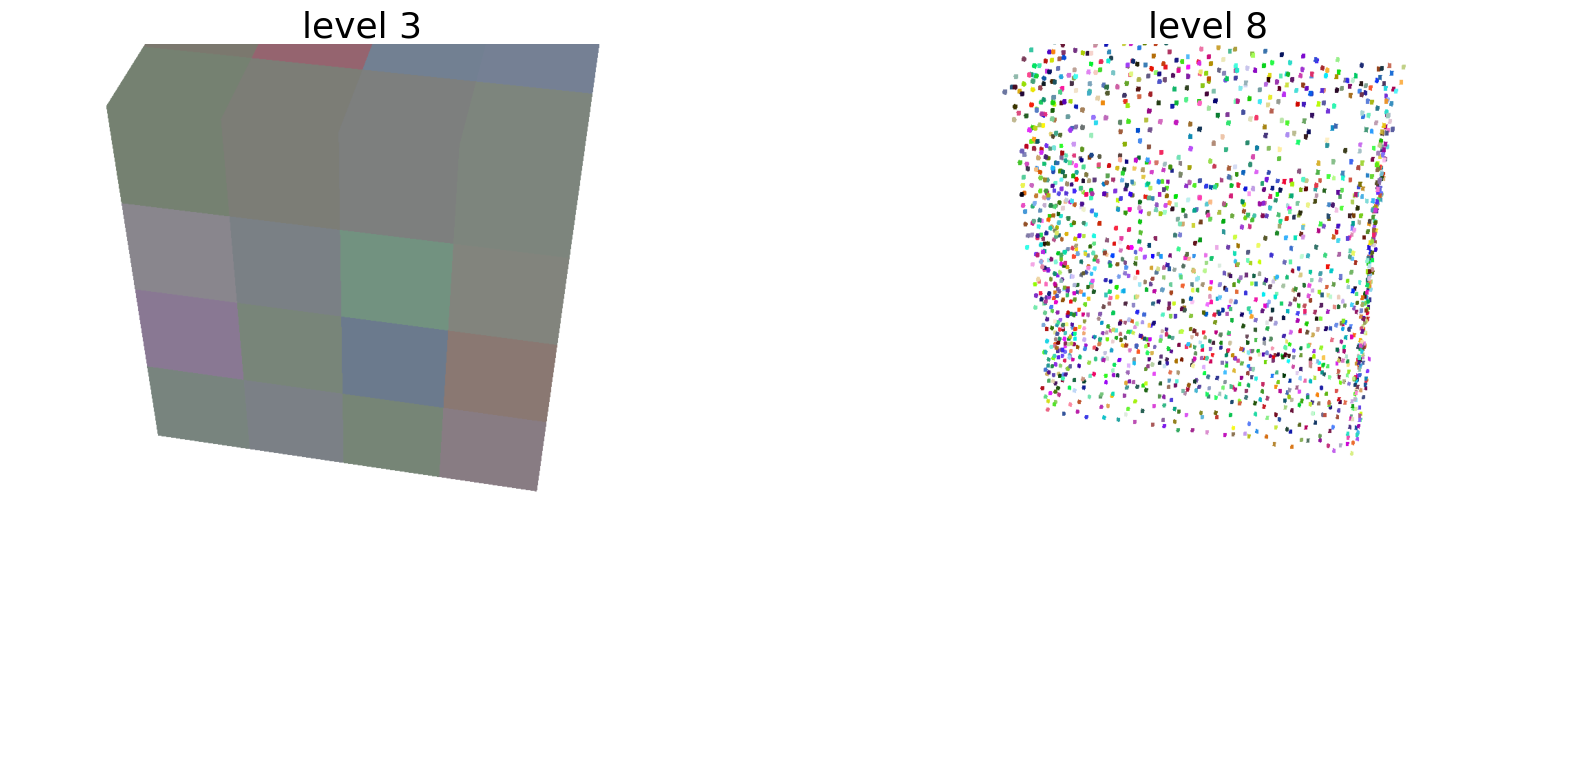

In [26]:
import matplotlib.pyplot as plt

def render(level):
    """ Create & render an image """
    spc = kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(torchPC, level, colors)
    octree, features, point_hierarchy, pyramid, prefix = spc.octrees, spc.features, spc.point_hierarchies, spc.pyramids[0], spc.exsum
    
    nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(octree, point_hierarchy, pyramid, prefix, ray_o, ray_d, level)
    print(f'Total of {nugs_ridx.shape[0]} nuggets were traced.\n')
    masked_nugs = kal.render.spc.mark_pack_boundaries(nugs_ridx)
    nugs_ridx = nugs_ridx[masked_nugs]
    nugs_pidx = nugs_pidx[masked_nugs]
    
    ridx = nugs_ridx.long()
    pidx = nugs_pidx.long() - pyramid[1,level]
    image = torch.ones_like(ray_o)
    image[ridx] = features[pidx]
    image = image.reshape(1024, 1024, 3)
    return image


fig = plt.figure(figsize=(20,10))

# Render left image of level 3 SPC
image1 = render(level=3)
image1 = image1.cpu().numpy().transpose(1,0,2)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("level 3", fontsize=26)
ax.axis('off')
plt.imshow(image1)

# Render right image of level 5 SPC
image2 = render(level=8)
image2 = image2.cpu().numpy().transpose(1,0,2)
ax = fig.add_subplot(1, 2, 2)
ax.set_title("level 8", fontsize=26)
ax.axis('off')
plt.imshow(image2)

plt.show()

In [60]:
# ==============================================================================================================
# The following snippet demonstrates the basic usage of kaolin's compressed octree,
# termed "Structured Point Cloud (SPC)".
# Note this is a low level structure: practitioners are encouraged to visit the references below.
# ==============================================================================================================
# See also:
#
#  - Code: kaolin.ops.spc.SPC
#    https://kaolin.readthedocs.io/en/latest/modules/kaolin.rep.html?highlight=SPC#kaolin.rep.Spc
#
#  - Tutorial: Understanding Structured Point Clouds (SPCs)
#    https://github.com/NVIDIAGameWorks/kaolin/blob/master/examples/tutorial/understanding_spcs_tutorial.ipynb
#
#  - Documentation: Structured Point Clouds
#    https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.spc.html?highlight=spc#kaolin-ops-spc
# ==============================================================================================================

import torch
import kaolin

# Construct SPC from some points data. Point coordinates are expected to be normalized to the range [-1, 1].
points = torch.tensor([[-1.0, -1.0, -1.0], [-0.9, -0.95, -1.0], [1.0, 1.0, 1.0]], device='cuda')


In [61]:
mp.plot(points.cpu().numpy(), shading={'point_color':'black', 'point_size':0.2})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [62]:

# In kaolin, operations are batched by default
# Here, in contrast, we use a single point cloud and therefore invoke an unbatched conversion function.
# The Structured Point Cloud will be using 3 levels of detail
spc = kaolin.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(pointcloud=points, level=3)


In [63]:

# SPC is a batched object, and most of its fields are packed.
# (see: https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.batch.html#kaolin-ops-batch )
# spc.length defines the boundaries between different batched SPC instances the same object holds.
# Here we keep track of a single entry batch, which has 8 octree non-leaf cells.
print(f'spc.batch_size: {spc.batch_size}')
print(f'spc.lengths (cells per batch entry): {spc.lengths}')


spc.batch_size: 1
spc.lengths (cells per batch entry): tensor([5], dtype=torch.int32)


In [64]:

# SPC is hierarchical and keeps information for every level of detail from 0 to 3.
# spc.point_hierarchies keeps the sparse, zero indexed coordinates of each occupied cell, per level.
print(f'SPC keeps track of total of {spc.point_hierarchies.shape[0]} parent + leaf cells:')


SPC keeps track of total of 7 parent + leaf cells:


In [65]:

# To separate the boundaries, the spc.pyramids field is used.
# This field is not-packed, unlike the other SPC fields.
pyramid_of_first_entry_in_batch = spc.pyramids[0]
cells_per_level = pyramid_of_first_entry_in_batch[0]
cumulative_cells_per_level = pyramid_of_first_entry_in_batch[1]
for i, lvl_cells in enumerate(cells_per_level[:-1]):
    print(f'LOD #{i} has {lvl_cells} cells.')


LOD #0 has 1 cells.
LOD #1 has 2 cells.
LOD #2 has 2 cells.
LOD #3 has 2 cells.


In [66]:
# The spc.octrees field keeps track of the fundamental occupancy information of each cell in the octree.
print('The occupancy of each octant parent cell, in Morton / Z-curve order is:')
print(['{0:08b}'.format(octree_byte) for octree_byte in spc.octrees])

# Since SPCs are low level objects, they require bookkeeping of multiple fields.
# For ease of use, these fields are collected and tracked within a single class: kaolin.ops.spc.SPC
# See references at the header for elaborate information on how to use this object.

The occupancy of each octant parent cell, in Morton / Z-curve order is:
['10000001', '00000001', '10000000', '00000001', '10000000']
